In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import clip
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# Zero Shot

In this experiment, we will measure the zero shot accuracy by calculating the similarity between an input encoding and the text encodings of CoCo classes.

# Load Model

In [3]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

Let's opt for simplicity and start with the smallest ResNet model (50)

In [4]:
name = 'RN50'
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

model, transform = clip.load(name, device=device, jit=False)

device: cuda


In [5]:
transform

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f31b5a3cc10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Load Data

## DataLoaders

In [6]:
coco_labels = []

with open('coco_labels.txt') as f:
    lines = f.readlines()
    for line in lines:
        line.replace('\n', '')
        coco_labels.append(line.replace('\n', ''))

In [7]:
from dataset import CocoCaseStudyDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR100

np.random.seed(0)

test_dataset = CocoCaseStudyDataset(split='test', experiment_type='zero', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in coco_labels]).to(device)

In [8]:
test_dataset.get_class_names()

['bench']

In [9]:
cls_index = coco_labels.index(test_dataset.get_class_names()[0])
cls_index

13

# Test

In [10]:
top1_predictions = []
top5_predictions = []
top10_predictions = []

for batch_ndx, (image, cls) in enumerate(test_dataloader):
    image = image.to('cuda')
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
        
    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    top1_predictions.append(similarity.topk(1)[1].detach().cpu().numpy())
    top5_predictions.append(similarity.topk(5)[1].detach().cpu().numpy())
    top10_predictions.append(similarity.topk(10)[1].detach().cpu().numpy())

top1_predictions = np.concatenate(top1_predictions, axis=0)
top5_predictions = np.concatenate(top5_predictions, axis=0)
top10_predictions = np.concatenate(top10_predictions, axis=0)


In [11]:
top1_acc = np.sum(top1_predictions==cls_index)/len(top1_predictions)
top5_acc = np.sum(top5_predictions==cls_index)/len(top1_predictions)
top10_acc = np.sum(top10_predictions==cls_index)/len(top1_predictions)

top1_acc, top5_acc, top10_acc

(0.7631578947368421, 0.9736842105263158, 1.0)

### Accuracy

Since bench is an object that is included in the contrastive pretraining, we can achieve 0.76 accuracy in top-1 accuracy. If the object wasn't included in the contrastive pretraining, we would have smaller similarity results. In order to understand the difference, we can set a threshold to the similarity.

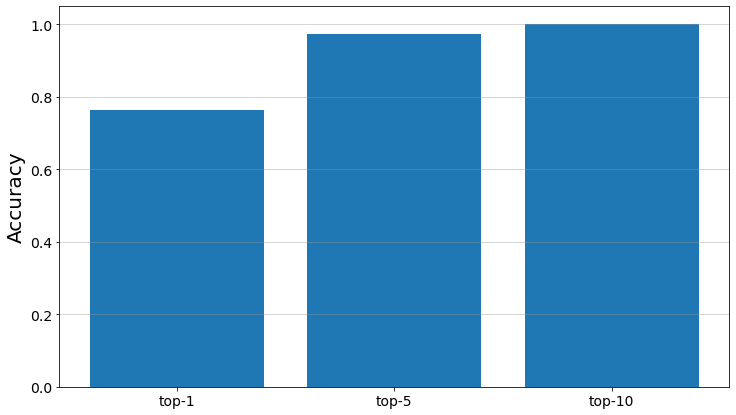

In [12]:
fig, ax = plt.subplots(figsize=(12,7))

ax.bar(['top-1', 'top-5', 'top-10'],[top1_acc, top5_acc, top10_acc])
# ax.set_ylim([0.6, 1])
# ax.set_title('Accuracies',fontsize=20)

plt.xticks(fontsize=14)
plt.grid(axis='y', linestyle='-',alpha=0.5,color='#999999')
plt.yticks(fontsize=14)
plt.ylabel('Accuracy',fontsize=20)
plt.show()